# Disease Infection/Transmission - The SIR Model

In this example, we will examine disease infection and transmission using the SIR (Susceptible/Infectious/Recovered) model. The SIR model is a relatively simple model describing the dynamics of infectious.  This model considers three populations, with the  dynamic behavior of each population defined be a differential equation.  The populations modeled include:

1. Susceptible - the population who are vulnerable to exposure of to the disease agent.
2. Infectious - the population that is infected and capable of transmitting the disease,
3. Recovered - the population that has been infected, recover, and as a result gain immunity to the disease.

The SIR model is a framework describing how the number of people in each group can change over time.

To capture this model, we need to define the processes that contribute individuals to, or remove individual from, each group. Conceptually, our model will describe the following:

1. **Susceptible (S)** - initially, we assume the entire population is suceptible; however, this population decreases as individuals become infected (and move to the Infectious pool).  The model assumes that the rate of infection is governed by the interaction of an infected individual with a susceptible individual, with the transmission rate controlled by a parameter $\beta$ that indicates the per-capita rate at which disease in transmitted from infectious to susceptible people.

2. **Infectious (I)** - Initially, we will assume a small population of infection individual exist in the population.  New infections result from transmission from infected to susceptible individuals as described above.  Additionally, infected individuals can recover from the disease - the per-capita recovery rate ($\gamma$) measures the portion of the infected population that can recover per unit time.

3. **Recovered (R)** - Initially, the recovered population is zero.  Ass infections and subsequent recovery occur, individual enter the Recovered pool.  Once recovered, individuals are assumed to be immune, and hence remain in the Recovered pool.

Capturing this conceptual model mathematically for a population size N results in the follow descriptions of the dynamics of this system:

$\large \frac{dS}{dt} = \frac{-\beta I S}{N} $

$\large \frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I $

$\large \frac{dR}{dt} = \gamma I $

Note that this model assumes no birth, immigration, or mortality; effectively the model assumes that these processes are insignificant over the time period of a given analysis.  Additionally, we note that the processes described above are the only ones accounted for by the model.  

To apply this model, we need to specify initial conditions and values for the two model parameters, $\beta$ and $\gamma$

Before implementing this model, we will define two additional terms:

**The average time to recovery (D)**, is derived from $\gamma$ as follows:

<p style="text-align:center"> $\large D = \frac{1}{\gamma} $ </p>

**The **basic reproduction number** ($R_0$)** is the average number of people infected from one other person. If it is high (e.g. > 1.0, the probability of pandemic increases.  If it is low (e.g. < 1) the probability decreases.

<p style="text-align:center"> $\large R_0 = \frac{\beta}{\gamma} $ </p>

To get a sense of this model's dynamics, let's examine a simple case before we dive into data.  We will assume the following:

1. We are modeling a new disease, **X**.  For this disease, we expect an infected person to transmit their infection to 1 person/day. This is $\beta$ in our equation above, and reflects the likelihood of transmission X the expected number of susceptible people contacted pre day.

2. For disease X, we will assume an individual remains infectious for 10 days.  This is the **D** parameter described above, and results in a $\gamma$ value of 0.1, and an $R_0$ value of 1/0.1 = 10.

3.  We've defined our two model parameters ($\beta$ and $\gamma$), all we need to solve the model is initial conditions.  We will assume a population size N of 1000, consisting of 999 susceptible individuals, 1 infected individual and no recovered individuals.  

Code implementing this model and parameters are provided below.

R0 = 2.00


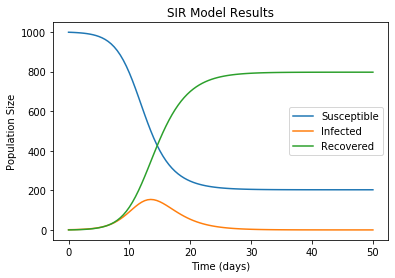

In [13]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def SIRModel(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

N = 1000    # total population size
beta = 1.0  # infected person infects 1 other person per day
D = 10      # infections lasts four days
gamma = 1.0 / D

print("R0 = {:.2f}".format(beta/gamma))

S0, I0, R0 = 999, 1, 0  # initial conditions: one infected, rest susceptible

times = np.arange(0, 50.1,0.5) # Grid of time points (in days)

# Integrate the SIR equations over the time grid, t.
Y = odeint(SIRModel, (S0,I0,R0), times, args=(N, beta, gamma))
S, I, R = Y.T

plt.plot(times,S,label='Susceptible')
plt.plot(times,I, label='Infected')
plt.plot(times,R,label='Recovered')
plt.title('SIR Model Results')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.legend()
plt.show()

As expected, the number of infections rise, until the remaining susceptible population is small enough that the tranmission rate decreases due to lack of remaining susceptible individuals. However,  infection continue until the entire population is infected.

Note the R<sub>0</sub> value for the $\beta$ and $\gamma$ values used (10).  Reducing R<sub>0</sub> by either reducing $\beta$ or increasing  $\gamma$ has a significant effect on the results.  For R<sub>0</sub> values greater than 1, the infection continues (faster for higher R<sub>0</sub> values, slower for lower R<sub>0</sub> values) throughout the entire population.  For R<sub>0</sub> values less than one, the infections quickly die out.

### Limitations of this model

This model makes numerous assumptions, and tehere for limitations reflecting those assumptions.  For example, a constant population size (no births, no mortality, no immigration) is assumed, no demographic data is considered, and no spatial variation is assumed (e.g. travel between cities). The model doesn't consider that there is often an asymptopmatic exposure period during with infected individuals are not infectious; nor does it consider varying levels of susceptibility across individuals in a population, nor effects of vaccination.

Still, this model has been successfully applied to a number of disease outbreaks. Regardless, to apply this model to a real-world disease outbreak, we need data to calibrate the model parameters N, $\beta$ and $\gamma$.

Below, we will calibrate and apply the model using a specific dataset for COVID-19 in the US.  Later, we will also consider possible modifications to the model relaxing some of the assumptions and limitations describe above.

## The COVID-19 Pandemic

Next, we will extend the model slightly to reflect some of the realities of the COVID-19 pandemic, and then calibrate our model parameters to real COVID-19 data.

We will extend the model in two ways. First, we will add the idea that **individuals can be exposed to the virus without becoming infectious for a period of time**.  To incorporate this into the model, we will add an additional population pool **E** (Exposed), placed "between" the susceptible and infected populations. forming what is referred to as the "**SEIR**" model (Susceptible/Exposed/Infected/Recovered). Mathematically, we will assume that additions to the Exposure pool from the Susceptible population follow the same dynamic as Susceptible-to-Infected in our previous model, and that a fixed percentage ($\delta$) of exposed individuals become infected per unit time.

Second, we will add an additional pool **M** for Mortality.   We will assume two possible outcomes resulting from infection: 1) Recovery (as in our prior model), or 2) Mortality (death).  We will need to define two new parameters:  $\rho$, the per-capita mortality rate (deaths/infected/day) for the portion of the Infected population that while die, and $\alpha$, the fraction of the Infected population that that will die and not recover.

As a result, our new SEIR model is:

$\large rExposed = \frac{-\beta I S}{N}  $

$\large rInfected = \delta E $

$\large rMortality = \alpha \rho I $

$\large rRecovery = (1 - \alpha) \gamma I $

$\large \frac{dS}{dt} = -rExposed $

$\large \frac{dE}{dt} = rExposed - rInfected $

$\large \frac{dI}{dt} =  rInfected - rMortality - rRecovered $

$\large \frac{dR}{dt} = rRecovered $

$\large \frac{dR}{dt} = rMortality $

We implement the model below with the following parameter values:

<table>
    <tr><th>Symbol</th><th>Parameter</th><th>Value</th></tr>
    <tr><td>N</td><td>Population Size (N)</td><td>1000</td></tr>
    <tr><td>$\beta$</td><td>per-capita rate at which disease is transmitted from infectious to susceptible people</td><td>1.0</td></tr>
    <tr><td>$\gamma$</td><td>per-capita recovery rate</td><td>0.1 (10 day recovery period)</td></tr>
    <tr><td>$\delta$</td><td>Percentage of exposed individuals that become infected per unit time</td><td>0.1</td></tr>
    <tr><td>$\alpha$</td><td>Fatality Fraction - portion of infected individuals that eventually die of the disease</td><td>0.20</td></tr>
    <tr><td>$\rho$</td><td>Fatality rate - per-capita rate at which mortality occurs in the portion of infected individuals that eventually die of the disease</td><td>0.10</td></tr></table>

The Python code below implement the modified model with the above parameters. 


R0 = 10.00


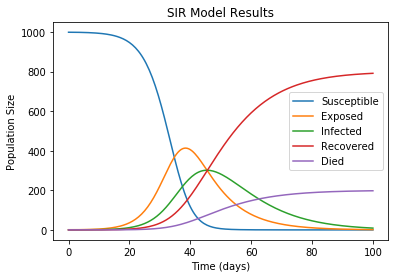

In [3]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def SEIRM_Model(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, M = y
    # calculate rates
    rExposed = beta * S * I / N
    rInfected = delta * E
    rMortality = alpha * rho * I
    rRecovered = (1-alpha)*gamma * I
    # calculate differentials
    dSdt = -rExposed
    dEdt = rExposed - rInfected
    dIdt = rInfected - rMortality - rRecovered
    dRdt = rRecovered
    dMdt = rMortality
    return dSdt, dEdt, dIdt, dRdt, dMdt

N = 1000    # total population size
beta = 1.0  # infected person infects 1 other person per day
D = 10      # infections lasts four days
gamma = 1.0 / D
delta = 0.1
alpha = 0.2
rho = 0.1

print("R0 = {:.2f}".format(beta/gamma))

S0, E0, I0, R0, M0 = 999, 1, 0, 0, 0  # initial conditions: one infected, rest susceptible

times = np.arange(0, 100.1,0.5) # Grid of time points (in days)

# Integrate the SIR equations over the time grid, t.
Y = odeint(SEIRM_Model, (S0,E0,I0,R0,M0), times, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, M = Y.T

plt.plot(times,S,label='Susceptible')
plt.plot(times,E, label='Exposed')
plt.plot(times,I, label='Infected')
plt.plot(times,R,label='Recovered')
plt.plot(times,M,label='Dead')
plt.title('SIR Model Results')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.legend()
plt.show()

## Interpreting the Modified Model

This model, while more complex, is arguably a better representation of actual transmission processes associated with COVID-19.  You might play around with the model, adjusting parameters to observe the implications for mortality and other variables.  

We also note that this model assumes all parameter values are constant through time.  We can easily modify this assumption by including a time-dependent function to determine parameter value dynamically.  For example, taking aggressive measures to control exposure to the virus would lower $\beta$ - we could define a function that raises or lowers $\beta$ as a function of the number of infections, reflecting reductions in exposures as masking protocols kick in in response to increasing infections.  

Many other such modifications are possible, but we will now turned to calibrating the model to real-world data. 

## Calibrating the Model with Real-world Data

We will need data to calibrate our model.  To do so, we need to consider what paramter values can be directly infered from the data, and what parameter values will need to be infered using the model results compared to data.     We will use COVID-19 compiled by John Hopkins University, described at https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases.  Specifically, we will utilize the csse_covid_19_time_series dataset available on the Github *2019 Novel Coronavirus COVID-19 (2019-nCoV) Data |Repository* at (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv).

Examining this data, it is not formatted particularly well for our analysis - the time series data is arrayed across columns, rather than rows, and contains data for all counties.  We will process the data abit to contain two columns - the data of the observation in a "Date" column, and the number of confirmed infections in a "Infections" column.

Records found: 1
Records found: 1
Records found: 1


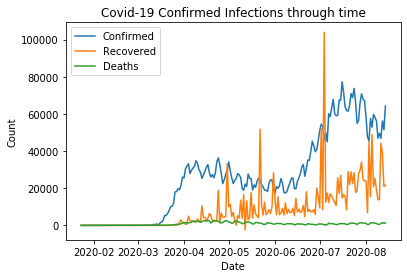

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def PrepData(file, country):
    df = pd.read_csv(file)
   
    # extract the location of interest (this should return a single record)
    df = df[(df['Country/Region'] == country)]
    print("Records found:", len(df.index)) 

    # swap rows and columns
    df = df.transpose()
    
    # Remove top 11 rows.  
    # Result table is one column, the case count, indexed by date
    df = df.iloc[4:,:]

    # extract the data
    dates = pd.to_datetime(df.index, format='%m/%d/%y')
    counts = df.iloc[:,0].to_numpy()
    
    # convert cumulative counts to daily rates
    counts = [(counts[i+1]-counts[i]) for i in range(0,len(counts)-1)]
    dates = dates[1:]  # trim first day, since we lost a day computing rates
    return dates, counts

# read a process the datasets
country = "US"
datesConfirmed, countsConfirmed = PrepData( "./time_series_covid19_confirmed_global.csv", country)
datesRecovered, countsRecovered = PrepData( "./time_series_covid19_recovered_global.csv", country)
datesDeaths, countsDeaths = PrepData( "./time_series_covid19_deaths_global.csv", country)

# plot results
plt.plot(datesConfirmed, countsConfirmed, label='Confirmed')
plt.plot(datesRecovered, countsRecovered, label='Recovered')
plt.plot(datesDeaths, countsDeaths, label='Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Covid-19 Confirmed Infections through time' )
plt.legend()
plt.show()

### Calculating Parameter Values

SOme parameters values we can calculate directly from the data, otheres we will need to estimate using a model fitting procedure.  In the first category are:

1. N, the total population size
2. 


beta = 1.0  # infected person infects 1 other person per day
D = 10      # infections lasts four days
gamma = 1.0 / D
delta = 0.1
alpha = 0.2
rho = 0.1

In [ ]:
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

def SEIRM_Model(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, M = y
    # calculate rates
    rExposed = beta * S * I / N
    rInfected = delta * E
    rMortality = alpha * rho * I
    rRecovered = (1-alpha)*gamma * I
    # calculate differentials
    dSdt = -rExposed
    dEdt = rExposed - rInfected
    dIdt = rInfected - rMortality - rRecovered
    dRdt = rRecovered
    dMdt = rMortality
    return dSdt, dEdt, dIdt, dRdt, dMdt


def RunModel(beta, delta, alpha, rho):
    N = 320000000   # total population size 
    #beta = 1.0  # infected person infects 1 other person per day
    D = 14      # infections lasts four days
    gamma = 1.0 / D
    #delta = 0.1
    #alpha = 0.2
    #rho = 0.1

    S0, E0, I0, R0, M0 = N-1, 1, 0, 0, 0  # initial conditions: one infected, rest susceptible

    times = np.arange(0, 100.1,0.5) # Grid of time points (in days)

    # Integrate the SIR equations over the time grid, t.
    Y = odeint(SEIRM_Model, (S0,E0,I0,R0,M0), times, args=(beta, delta, alpha, rho))
    # S, E, I, R, M = Y.T
    return Y.T
    
def OptFn(beta, delta, alpha, rho):
    S, E, I, R, M = RunModel( beta, delta, alpha, rho)
    
    # Goal is to minimize error, so let's calculate an error term
    for 

# initial guesses
beta = 1.0  # infected person infects 1 other person per day
delta = 0.1
alpha = 0.2
rho = 0.1

result = minimize(OptFn, (beta, delta, alpha, rho))
print result;
    
    
    
"""
print("R0 = {:.2f}".format(beta/gamma))

plt.plot(times,S,label='Susceptible')
plt.plot(times,E, label='Exposed')
plt.plot(times,I, label='Infected')
plt.plot(times,R,label='Recovered')
plt.plot(times,M,label='Dead')
plt.title('SIR Model Results')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.legend()
plt.show()
"""